# Wave RNN Gradient Norm

This notebook is used to investigate the gradient norm of Wave RNN.

In [21]:
%matplotlib inline

import sys

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

from src.bin.signal_model._utils import set_hparams

set_hparams()

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'

In [ ]:
from src.bin.signal_model._utils import load_data

train, dev = load_data(real_train='../data/.feature_dataset/train',
                  real_dev='../data/.feature_dataset/dev')

In [ ]:
row = train[1]
# [batch_size, local_length, local_features_size]
local_features = row['slice']['log_mel_spectrogram'].unsqueeze(0) 
# [batch_size, signal_length, 2]
input_signal = row['slice']['input_signal'].unsqueeze(0)
# [batch_size, signal_length, 1]
target_coarse = row['slice']['target_signal_coarse'].unsqueeze(0).unsqueeze(2) 

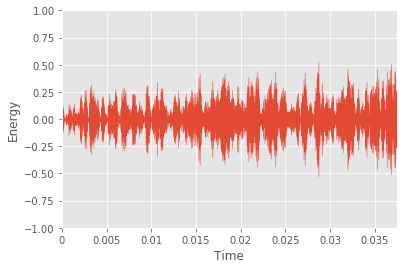

In [54]:
from src.utils import plot_waveform
from src.utils import combine_signal

signal = combine_signal(row['slice']['target_signal_coarse'], row['slice']['target_signal_fine'])
_ = plot_waveform(signal.numpy())

In [22]:
signal_model_checkpoint = ('/home/michaelp/Tacotron-2/experiments/signal_model/07_07/initial_hidden_state/'
                            'checkpoints/1530981491/step_386988.pt')

In [55]:
from src.bin.signal_model._utils import load_checkpoint
from torch.nn import CrossEntropyLoss

# Load Model
checkpoint = load_checkpoint(signal_model_checkpoint)
print(checkpoint['model'])

# Run
predicted_coarse, predicted_fine, hidden = checkpoint['model'](local_features, input_signal, target_coarse)
predicted_coarse = predicted_coarse.transpose(1, 2)
predicted_fine = predicted_fine.transpose(1, 2)

for i in range(0, 900, 50):
    # Evaluate
    target_signal_coarse = row['slice']['target_signal_coarse'].unsqueeze(0).long()
    target_signal_fine = row['slice']['target_signal_fine'].unsqueeze(0).long()
    loss = CrossEntropyLoss()(predicted_coarse[:, :, :i], target_signal_coarse[:, :i])
    loss += CrossEntropyLoss()(predicted_fine[:, :, :i], target_signal_fine[:, :i])
    
    # Get gradient norm
    checkpoint['optimizer'].zero_grad()
    loss.backward(retain_graph=True)
    params = itertools.chain.from_iterable(
        [group['params'] for group in checkpoint['optimizer'].optimizer.param_groups])
    parameter_norm = torch.nn.utils.clip_grad_norm_(params, 100)
    print('Gradient over %d steps with shape %s:' % (i, predicted_coarse[:, :, :i].shape), parameter_norm)

/home/michaelp/.local/lib/python3.5/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'src.signal_model.wave_rnn.WaveRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


WaveRNN(
  (to_bins_coarse): Sequential(
    (0): Linear(in_features=448, out_features=448, bias=True)
    (1): ReLU()
    (2): Linear(in_features=448, out_features=256, bias=True)
  )
  (to_bins_fine): Sequential(
    (0): Linear(in_features=448, out_features=448, bias=True)
    (1): ReLU()
    (2): Linear(in_features=448, out_features=256, bias=True)
  )
  (project_coarse_input): Linear(in_features=2, out_features=1344, bias=False)
  (project_fine_input): Linear(in_features=3, out_features=1344, bias=False)
  (conditional_features_upsample): ConditionalFeaturesUpsample(
    (upsample_signal_length): Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(1, 4), stride=(1, 4))
    )
    (upsample_layers): ModuleList(
      (0): Conv1d(80, 2688, kernel_size=(1,), stride=(1,))
    )
  )
  (stripped_gru): StrippedGRU(
    (gru): GRU(2688, 896)
  )
)
Gradient over 0 steps with shape torch.Size([1, 256]): tensor(4557.6079)
Gradient over 50 steps with shape torch.Size([1, 256, 50]): tenso